In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import mstats
import os
import importlib

In [3]:
# --- Step 1: Load Data ---
file_path = os.getcwd() + '/data/Factor_data.xlsx'
df = pd.read_excel(file_path, sheet_name='mf', index_col=0)
df = df.tail(24).copy()

"""
# Winsorize and standardize factors
for col in ['Quality', 'Momentum', 'Value', 'Low_vol', 'Market']:
    df[col] = mstats.winsorize(df[col], limits=[0.05, 0.05])
    df[col] = (df[col] - df[col].mean()) / df[col].std()
"""

"\n# Winsorize and standardize factors\nfor col in ['Quality', 'Momentum', 'Value', 'Low_vol', 'Market']:\n    df[col] = mstats.winsorize(df[col], limits=[0.05, 0.05])\n    df[col] = (df[col] - df[col].mean()) / df[col].std()\n"

In [4]:
market_neutral_factors = {}

for factor in ['Quality', 'Momentum', 'Value', 'Low_vol']:
    # Prepare regression variables
    x_market = sm.add_constant(df['Market'])
    y_factor = df[factor]
    
    # Run regression
    model = sm.OLS(y_factor, x_market).fit()
    
    # Get residuals (market-neutral factor returns)
    market_neutral_factors[factor] = model.resid

# Add market-neutral factors to DataFrame
for factor in market_neutral_factors:
    df[f'{factor}_mn'] = market_neutral_factors[factor]

# Now use ['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn'] as your factors in further analysis

print(df.columns)

Index(['Net Return', 'Benchmark Return', 'Quality', 'Momentum', 'Value',
       'Low_vol', 'Market', 'Quality_mn', 'Momentum_mn', 'Value_mn',
       'Low_vol_mn'],
      dtype='object')


In [5]:
# --- Step 3: Prepare Regression Variables ---
X = df[['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn', 'Market']]
# X = df[['Quality', 'Momentum', 'Value', 'Low_vol']]
# X = df[['Quality', 'Momentum', 'Value', 'Low_vol', 'Market']]
# X = df[['Benchmark Return']]
y = df['Net Return']  # or df['Benchmark Return']

# Add constant for intercept
X = sm.add_constant(X)

# --- Step 4: Run Regression ---
model = sm.OLS(y, X).fit()
print(model.summary())

# --- Step 5: Get Betas (Factor Sensitivities) ---
betas = model.params.drop('const')
print(betas)

                            OLS Regression Results                            
Dep. Variable:             Net Return   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1.586
Date:                Tue, 16 Sep 2025   Prob (F-statistic):              0.215
Time:                        12:27:49   Log-Likelihood:                 39.265
No. Observations:                  24   AIC:                            -66.53
Df Residuals:                      18   BIC:                            -59.46
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0183      0.012      1.585      

In [6]:
# --- Step 6: Calculate Factor Variances and Covariances ---
factor_returns = df[['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn', 'Market']]
#factor_returns = df[['Quality', 'Momentum', 'Value', 'Low_vol']] 
# factor_returns = df[['Quality', 'Momentum', 'Value', 'Low_vol', 'Market']]
factor_cov = factor_returns.cov()
factor_var = factor_returns.var()

factor_cov

,Quality_mn,Momentum_mn,Value_mn,Low_vol_mn,Market
Quality_mn,4.725405e-04,1.767373e-04,2.314677e-04,6.721852e-05,3.865416e-19
Momentum_mn,1.767373e-04,5.056763e-04,3.222719e-04,-5.608919e-05,4.572505e-19
Value_mn,2.314677e-04,3.222719e-04,8.200273e-04,4.973567e-05,6.693770e-19
Low_vol_mn,6.721852e-05,-5.608919e-05,4.973567e-05,1.994157e-04,5.468150e-19
Market,3.865416e-19,4.572505e-19,6.693770e-19,5.468150e-19,1.703626e-03


In [7]:
# --- Step 7: Calculate Risk Attribution ---
# Portfolio variance explained by factors
risk_contributions = {}
for i, factor in enumerate(factor_returns.columns):
    # Variance term
    var_term = betas[factor]**2 * factor_var[factor]
    # Covariance terms
    cov_term = 0
    for j, other_factor in enumerate(factor_returns.columns):
        if i != j:
            cov_term += betas[factor] * betas[other_factor] * factor_cov.loc[factor, other_factor]
    # Total contribution
    risk_contributions[factor] = var_term + cov_term

# Residual (unexplained) risk
residual_var = model.resid.var()

# --- Step 8: Summarize Results ---
total_risk = sum(risk_contributions.values()) + residual_var

print("\nRisk Attribution (Absolute):")
for factor, contribution in risk_contributions.items():
    print(f"{factor}: {contribution:.6f} ({contribution/total_risk:.2%} of total risk)")
print(f"Residual: {residual_var:.6f} ({residual_var/total_risk:.2%} of total risk)")
print(f"Total Portfolio Variance: {total_risk:.6f}")


Risk Attribution (Absolute):
Quality_mn: 0.000229 (6.87% of total risk)
Momentum_mn: 0.000477 (14.29% of total risk)
Value_mn: -0.000022 (-0.66% of total risk)
Low_vol_mn: 0.000039 (1.18% of total risk)
Market: 0.000297 (8.90% of total risk)
Residual: 0.002317 (69.42% of total risk)
Total Portfolio Variance: 0.003338


Portfolio Risk Attribution Analysis
Total Portfolio Variance: 0.003338

Risk Attribution Table:
     Factor  Absolute_Risk  Risk_Percentage
 Quality_mn       0.000229         6.869199
Momentum_mn       0.000477        14.286945
   Value_mn      -0.000022        -0.662055
 Low_vol_mn       0.000039         1.182518
     Market       0.000297         8.899418
   Residual       0.002317        69.423975


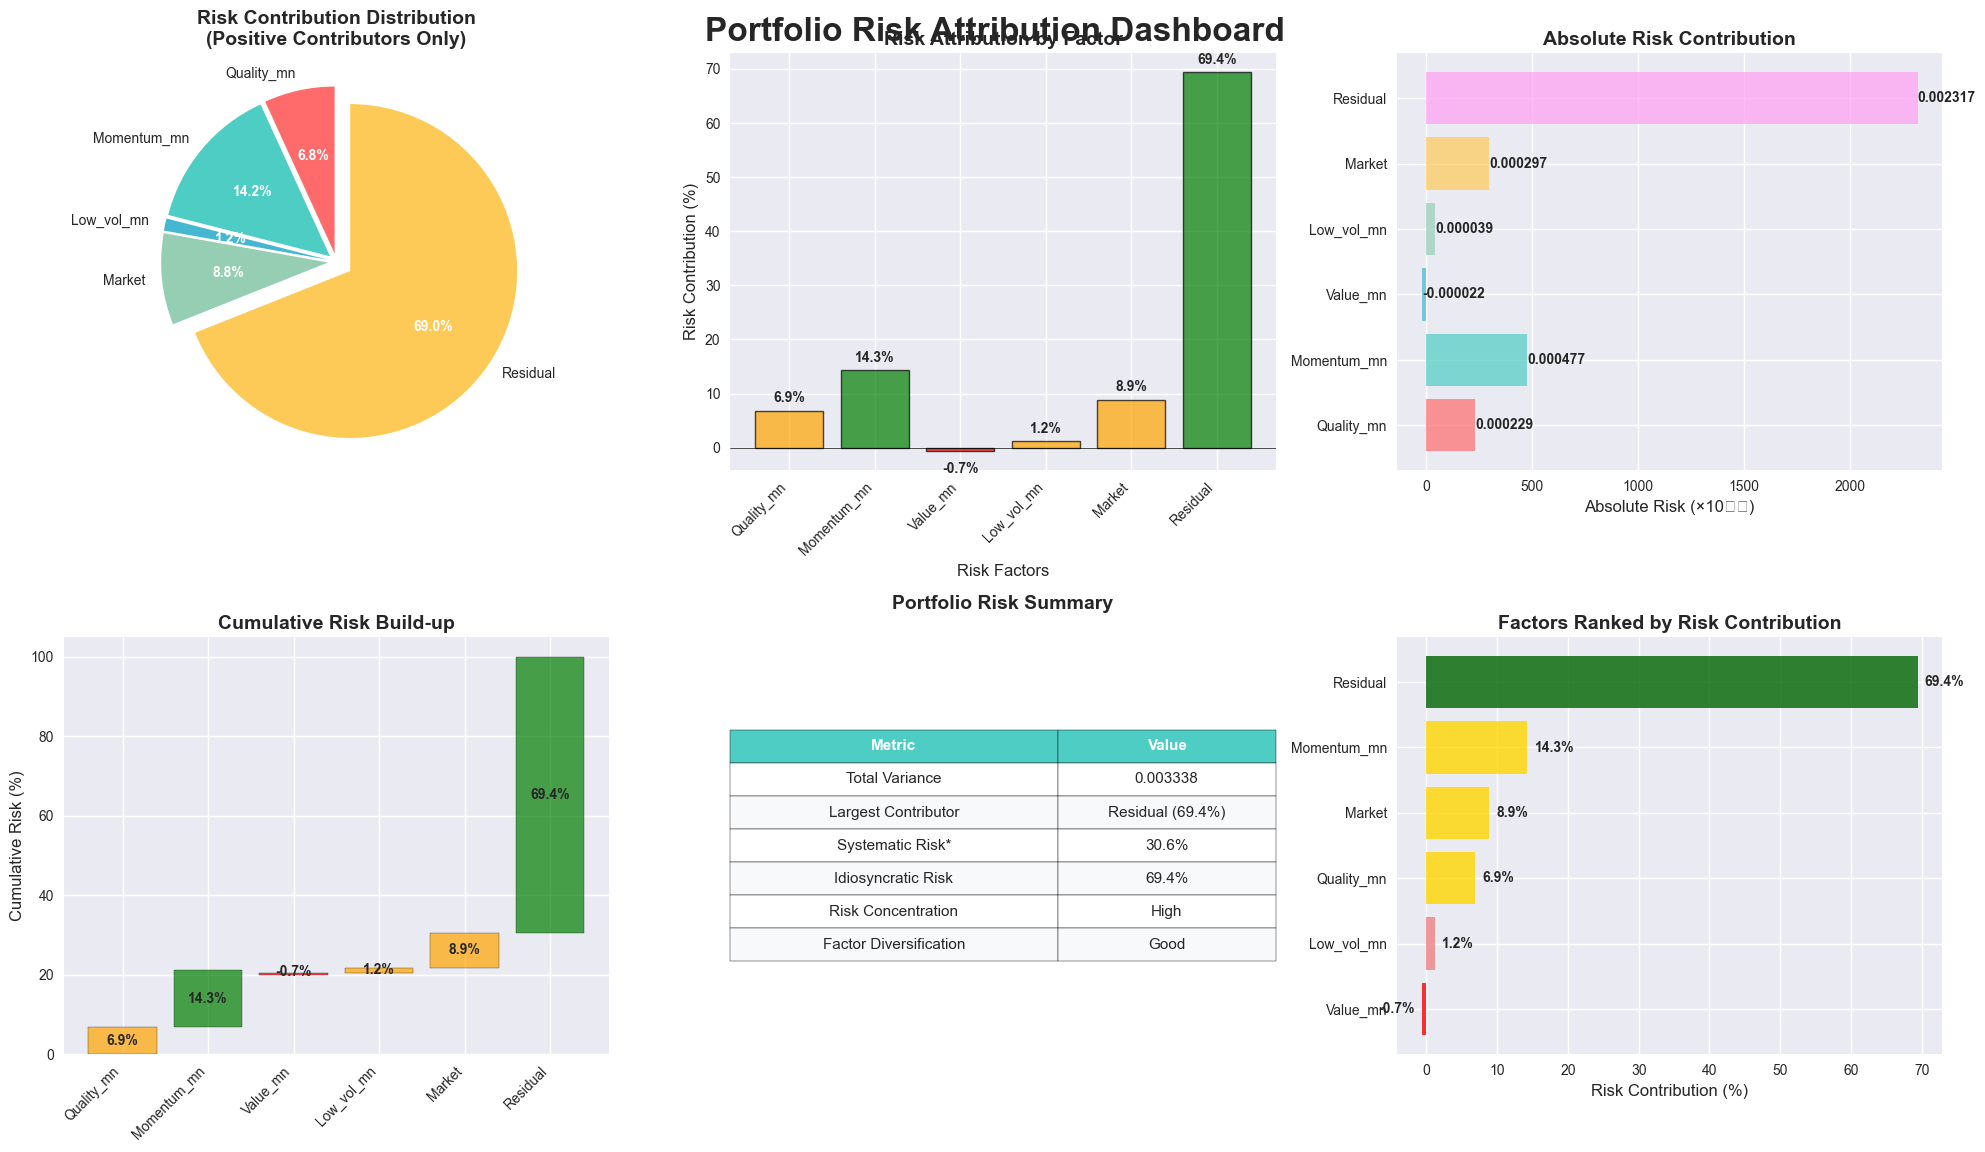


RISK ANALYSIS INSIGHTS

🔍 KEY FINDINGS:
• Residual risk dominates the portfolio (69.4%)
• Systematic risk factors contribute 30.6% of total risk
• Residual is the largest systematic contributor (69.4%)
• Portfolio shows MODERATE concentration risk

📊 RISK DECOMPOSITION:
• Quality_mn  :   6.87% 🟢 LOW
• Momentum_mn :  14.29% 🟡 MEDIUM
• Value_mn    :  -0.66% 🟢 LOW
• Low_vol_mn  :   1.18% 🟢 LOW
• Market      :   8.90% 🟢 LOW
• Residual    :  69.42% 🔴 HIGH

💡 RECOMMENDATIONS:
• Consider increasing factor exposure to reduce idiosyncratic risk

Note: *Systematic Risk = Sum of all factor risks excluding residual


In [10]:
import libraries.help as help
importlib.reload(help)

# Build dataframe
df = pd.DataFrame([
    {"Factor": factor,
     "Absolute_Risk": contrib,
     "Risk_Percentage": (contrib / total_risk) * 100}
    for factor, contrib in risk_contributions.items()
] + [{
    "Factor": "Residual",
    "Absolute_Risk": residual_var,
    "Risk_Percentage": (residual_var / total_risk) * 100
}])

help.plot_risk_attribution(df, total_risk, title="Portfolio Risk Attribution Dashboard")

In [11]:
# --- Step 9: Attribution Calculation ---
betas = model.params.drop('const')
alpha = model.params['const']
avg_factors = X.drop('const', axis=1).mean()

# Factor contributions
factor_contributions = betas * avg_factors

# Alpha contribution
alpha_contribution = alpha

# Residual (unexplained) contribution
residuals = model.resid
residual_contribution = residuals.mean()

# Total (should match average net return)
total_contribution = factor_contributions.sum() + alpha_contribution + residual_contribution

# --- Step 6: Display Results ---
print("Return Attribution (last 36 rows):")
print(f"Alpha: {alpha_contribution:.6%}")
for factor in betas.index:
    print(f"{factor}: {factor_contributions[factor]:.6%}")
print(f"Residual: {residual_contribution:.6%}")
print(f"Total: {total_contribution:.6%} (should match average Net Return: {y.mean():.6%})")

Return Attribution (last 36 rows):
Alpha: 1.829050%
Quality_mn: -0.000000%
Momentum_mn: -0.000000%
Value_mn: 0.000000%
Low_vol_mn: -0.000000%
Market: 0.475522%
Residual: -0.000000%
Total: 2.304572% (should match average Net Return: 2.304572%)


In [ ]:
# --- Step 9: Attribution Calculation for any single period ---
period = -1  # Change this to the desired period index (0-based)
betas = model.params.drop('const')
alpha = model.params['const']

# Use the last period factors instead of average
last_factors = X.drop('const', axis=1).iloc[period]

# Factor contributions
factor_contributions = betas * last_factors

# Alpha contribution
alpha_contribution = alpha

# Residual (unexplained) contribution for last period
residuals = model.resid
residual_contribution = residuals.iloc[period]

# Total (should match last period Net Return)
total_contribution = factor_contributions.sum() + alpha_contribution + residual_contribution

# --- Step 6: Display Results ---
print("Return Attribution (last period):")
print(f"Alpha: {alpha_contribution:.2%}")
for factor in betas.index:
    print(f"{factor}: {factor_contributions[factor]:.2%}")
print(f"Residual: {residual_contribution:.2%}")
print(f"Total: {total_contribution:.2%} (should match Net Return last period: {y.iloc[period]:.2%})")


Return Attribution (last period):
Alpha: 1.83%
Quality_mn: 0.90%
Momentum_mn: 0.69%
Value_mn: 0.96%
Low_vol_mn: 0.64%
Market: -0.81%
Residual: -7.25%
Total: -3.06% (should match Net Return last period: -3.06%)
